# Background

The current (as of 2020-08-14) parking availability prediction models produced by Hong and Yuxiao do not operate at the level of individual parking meters or zones.
Instead, parking meters and zones are aggregated into "zone clusters" exposed by the `app.zone_info` module.
The choice of clusters plays a key role in what the parking availability model is predicting, and it will be important to document what the clusters look like with the current clustering algorithm for comparison and validation as we modify the system.

# Pre-Requisites

In [1]:
from pathlib import Path

import colorcet as cc
import git
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import osmnx as ox
import pandas as pd

from shapely.geometry import Point

REPO_ROOT = Path(git.Repo('.', search_parent_directories=True).working_tree_dir).absolute()
DATA_RAW_PATH = REPO_ROOT / 'data' / 'raw'
DATA_RAW_PATH.mkdir(parents=True, exist_ok=True)

%cd $REPO_ROOT

/Users/daniel.r.moore/workspace/PredictiveParking


# Retrieving Parking Zone Clusters

In [2]:
import app.zone_info as zone_info

zone_clusters = zone_info.zone_cluster()

display(zone_clusters.head())
print('Total Clusters:', zone_clusters.clusterID.nunique())
zone_clusters.groupby('clusterID').size().quantile([0, .25, .5, .75, 1])

,zoneID,clusterID
0,31001,5
1,31002,3
2,31003,12
3,31004,6
4,31005,6


Total Clusters: 16


0.00     1.00
0.25     5.25
0.50     8.00
0.75    10.00
1.00    31.00
dtype: float64

# Retrieving Zone Representatives
The CSV that `zone_info.zone_clusters` is based on does not contain any geospatial information about each zone. As a simple first pass at understanding where different zones are located, we'll attempt to match zones in this list with the "Subarea Names" of parking meters in the [2020 IPS Parking Meter Inventory](https://discovery.smartcolumbusos.com/dataset/ips_group/parking_meter_inventory_2020).

In [3]:
ips_meters_source = 'https://scos-alm-ckan-csv-backup.s3.us-east-2.amazonaws.com/public/Columbus+Parking+Meters/ColumbusParkingMeterInventory_01062020.csv'
ips_meters_target = DATA_RAW_PATH / 'IPS_Columbus_Parking_Meters_Inventory_2020.csv'

if not ips_meters_target.exists():
    !wget -O $ips_meters_target $ips_meters_source

ips_meters = pd.read_csv(ips_meters_target)

## Massive Disclaimer
My objective in this notebook is to determine whether or not parking meters are clustered based on their geospatial properties or other methods. As we'll see in the visualization below, we can obtain satisfactory results just using the aforementioned IPS inventory. For other questions, however, just matching subarea names in the inventory to zone IDs used by `zone_info.zone_clusters` is far from ideal. Doing so will not provide a perfect parking sources-to-clusters mapping, since it's disregarding
1. zones that are determined by Fybr sensors and unmetered city parking zones, and
2. meters in subareas from the IPS Parking Meter Inventory with non-numeric names.
If there is a need to dive deeper into Hong and Yuxiao's work in the future, it will require a more comprehensive mapping of parking sources into the zones/clusters provided by `zone_info`.

Indeed, considering only meters with numeric zones disregards most of the IPS meters in the city.

In [4]:
(ips_meters.groupby(ips_meters.SubAreaName.str.isnumeric(), as_index=False)
           .size()
           .rename(columns={'SubAreaName': 'Numeric Subarea Name', 'size': 'Total Meters'})
           .set_index('Numeric Subarea Name'))

,Total Meters
Numeric Subarea Name,
False,3814
True,707


# Visualizing Parking Meter Clusters
With that disclaimer out of the way, let's take a look at how IPS parking meters with numeric subarea names are distributed throughout Columbus.

## Geospatializing our Zone Clusters

In [5]:
ips_meters_int_subareas = (
    ips_meters[ips_meters.SubAreaName.str.isnumeric()]
        .assign(SubAreaName=lambda df: df.SubAreaName.astype(int))
)

zone_examples = gpd.GeoDataFrame(
    pd.merge(
        left=zone_clusters,
        right=ips_meters_int_subareas,
        how='left',
        left_on='zoneID',
        right_on='SubAreaName'
    ).assign(
        geometry=lambda df: list(map(Point, zip(df.Long, df.Lat)))
    ).drop(columns=['Long', 'Lat', 'SubAreaName']).dropna(),
    geometry='geometry'
)

## Fetching the Columbus Road Network

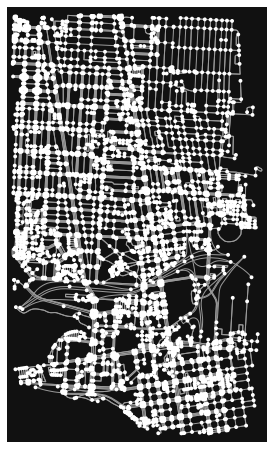

In [6]:
west, south, east, north = zone_examples.geometry.unary_union.buffer(.0005).bounds
ew_dilation = .0001
Cbus = ox.graph_from_bbox(north, south, (1 - ew_dilation) * east, (1 + ew_dilation) * west)

ox.plot_graph(Cbus);

## Layering Cluster Representatives onto the Network

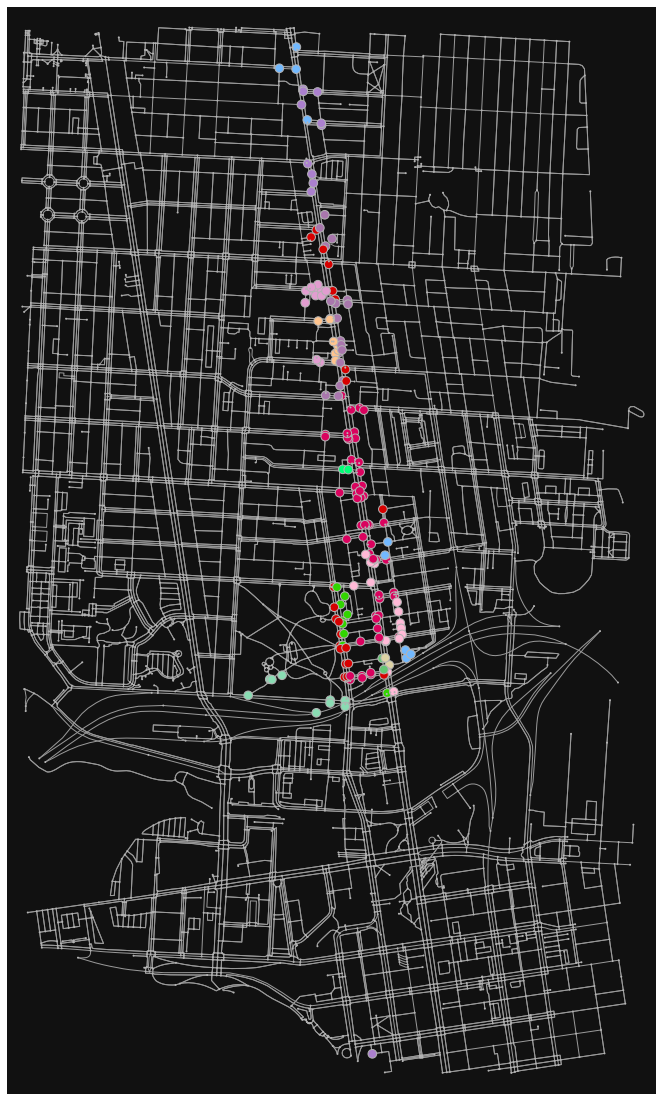

In [7]:
nearest_nodes = list(ox.get_nearest_nodes(Cbus, zone_examples.geometry.x, zone_examples.geometry.y))
zone_examples['nearest_node'] = nearest_nodes

cmap = cc.cm.glasbey_light
color_normalizer = mpl.colors.Normalize(vmin=zone_examples.clusterID.min(), vmax=zone_examples.clusterID.max())

ox.plot_graph(
    Cbus,
    node_color=[cmap(color_normalizer(zone_examples.iloc[nearest_nodes.index(node)]['clusterID']))
                if node in nearest_nodes else (0.6, 0.6, 0.6, 0.3) for node in Cbus.nodes],
    node_size=[75 if node in nearest_nodes else 1 for node in Cbus.nodes],
    node_edgecolor=(0.7, 0.7, 0.7, 1),
    node_zorder=2,
    node_alpha=None,
    figsize=(20, 20),
    close=True
);

# Discussion
There are at least two relevant conclusions we can draw from this map:
1. **There is a geospatial component to the current clustering algorithm.** Most of the clusters consist of parking meters that are nearby one another or appear along contiguous sections of roadway.
2. **Non-geospatial features are being used.** As an obvious example, the purple cluster is a combination of parking meters along High Street in the upper half of the image and a single parking meter at the base of the image.

I also think that it is fair to say that **this clustering algorithm is counterintuitive.** It seems reasonable to assume that the availabilities of parking meters $A$ and $B$ are uncorrelated if $A$ and $B$ are large walking distances away from one another. Since drivers are not generally willing to pay for parking miles from their destinations, parking meter $A$ being in-use should only (negatively) impact parking meters that are nearby from a pedestrian's perspective. Given that per-cluster predictions do not currently factor in geospatial information, it is surprising to see clusters wherein the minimum walking distance between two parking meters is in excess of one mile.

An interesting experiment going forward would involve comparing the performance of the current prediction models using these clusters versus clusters that are created solely based on geospatial information.